In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm

## Read data

In [62]:
train = pd.read_csv("loan_train.csv")
train.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


In [63]:
for col in train.columns:
    print(train[col].unique())

['Male' 'Female' nan]
['No' 'Yes' nan]
['0' '1' '2' '3+' nan]
['Graduate' 'Not Graduate']
['No' 'Yes' nan]
[ 584900  458300  300000  258300  600000  541700  233300  303600  400600
 1284100  320000  250000  307300  185300  129900  495000  359600  351000
  488700  260000  766000  595500  336500  371700  956000  279900  422600
  144200  375000  416600  316700  469200  350000 1250000  227500  182800
  366700  374800  360000  180000  240000  394100  469500  341000  564900
  582100  264500  400000  192800  308600  423000  461600 1150000  270800
  213200  336600  808000  335700  302900  260900  494500  572600 1075000
  710000  430000  320800  187500  475500  526600  100000  333300  384600
  239500  137800  398800  236600  856600  569500  295800  625000  327300
  413300  362000  678200  248400  197700  418800  175900  428800  484300
 1365000  465200  381600  305200 1141700  733300  380000  207100  531600
  292900  357200  745100  505000 1458300  221400  556800 1040800  566700
  213700  295700 

In [64]:
# nan gender will be (0,0)
train["Male"] = 0
train["Female"] = 0
train.loc[train.Gender == "Male", "Male"] = 1
train.loc[train.Gender == "Female", "Female"] = 1
train["IsMarried"] = 0
num_married = (train.Married == "Yes").sum()
num_unmarried = (train.Married == "No").sum()
if num_married > num_unmarried:
    # nan will be married
    train.loc[train.Married != "No", "IsMarried"] = 1
else:
    # nan will be unmarried
    train.loc[train.Married == "Yes", "IsMarried"] = 1
has_zero_dependent = (train.Dependents == "0").sum()
has_one_dependent = (train.Dependents == "1").sum()
has_two_dependent = (train.Dependents == "2").sum()
has_three_plus_dependent = (train.Dependents == "3+").sum()
max_count_dependent = train.Dependents.value_counts().max()
train["NumDependents"] = 0
if has_zero_dependent == max_count_dependent:
    # nan will be 0; so do nothing
    train.loc[train.Dependents == "1", "NumDependents"] = 1
    train.loc[train.Dependents == "2", "NumDependents"] = 2
    # convert 3+ to 3
    train.loc[train.Dependents == "3+", "NumDependents"] = 3
elif has_one_dependent == max_count_dependent:
    # nan will be 1
    train.loc[(train.Dependents != "0") &
              (train.Dependents != "2") &
              (train.Dependents != "3+"), "NumDependents"] = 1
    train.loc[train.Dependents == "2", "NumDependents"] = 2
    # convert 3+ to 3
    train.loc[train.Dependents == "3+", "NumDependents"] = 3
elif has_two_dependent == max_count_dependent:
    train.loc[train.Dependents == "1", "NumDependents"] = 1
    # nan will be 2
    train.loc[(train.Dependents != "0") &
              (train.Dependents != "1") &
              (train.Dependents != "3+"), "NumDependents"] = 2
    # convert 3+ to 3
    train.loc[train.Dependents == "3+", "NumDependents"] = 3
else: # max == 3+
    train.loc[train.Dependents == "1", "NumDependents"] = 1
    train.loc[train.Dependents == "2", "NumDependents"] = 2
    # nan will be 3+ & convert 3+ to 3
    train.loc[(train.Dependents != "0") &
              (train.Dependents != "1") &
              (train.Dependents != "2"), "NumDependents"] = 3       
train["Graduated"] = 0
num_graduated = (train.Education == "Graduate").sum()
num_ungraduated = (train.Education == "Not Graduate").sum()
if num_graduated > num_ungraduated:
    train.loc[train.Education != "Not Graduate", "Graduated"] = 1
else:
    train.loc[train.Education == "Graduate", "Graduated"] = 1
train["IsSelfEmployed"] = 0
num_self_employed = (train.Self_Employed == "Yes").sum()
num_not_self_employed = (train.Self_Employed == "No").sum()
if num_self_employed > num_not_self_employed:
    train.loc[train.Self_Employed != "No", "IsSelfEmployed"] = 1
else:
    train.loc[train.Self_Employed == "Yes", "IsSelfEmployed"] = 1
num_w_credit_hist = (train.Credit_History == 1.0).sum()
num_wo_credit_hist = (train.Credit_History == 0.0).sum()
if num_w_credit_hist > num_wo_credit_hist:
    train.loc[train.Self_Employed != 0.0, "Credit_History"] = 1.0
else:
    train.loc[train.Self_Employed != 1.0, "Credit_History"] = 0.0
# term
train.loc[train.Term.isna(), "Term"] = train.Term.value_counts().max()
train["Urban"] = 0
train["Rural"] = 0
train.loc[train.Area == "Urban", "Urban"] = 1
train.loc[train.Area == "Rural", "Rural"] = 1
train["y"] = 0
train.loc[train.Status == "Y", "y"] = 1

In [65]:
train = train[["Applicant_Income", "Coapplicant_Income",
               "Loan_Amount", "Term", "Male", "Female",
               "IsMarried", "NumDependents",
               "Graduated", "IsSelfEmployed",
               "Urban", "Rural", "y"]]

In [66]:
train_x.apply(lambda x: x.dtype)

Applicant_Income        int64
Coapplicant_Income    float64
Loan_Amount             int64
Term                  float64
Male                    int64
Female                  int64
IsMarried               int64
NumDependents           int64
Graduated               int64
IsSelfEmployed          int64
Urban                   int64
Rural                   int64
dtype: object

C:\Users\chihy\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


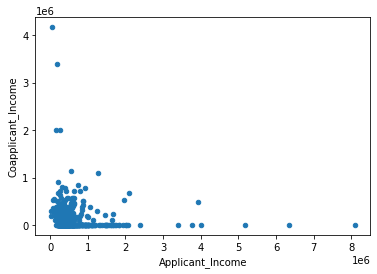

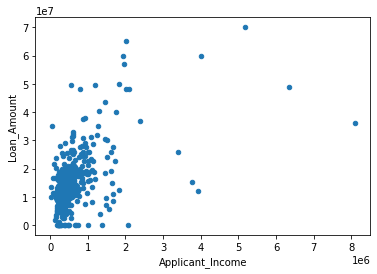

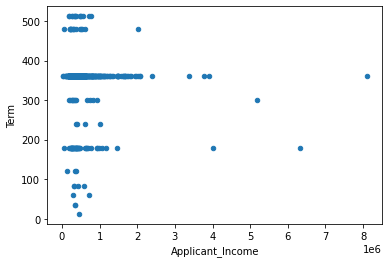

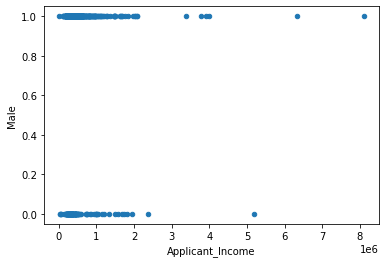

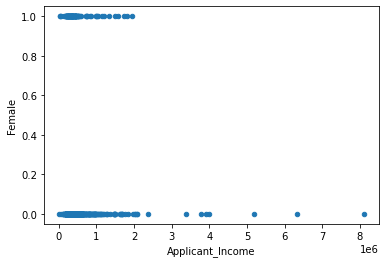

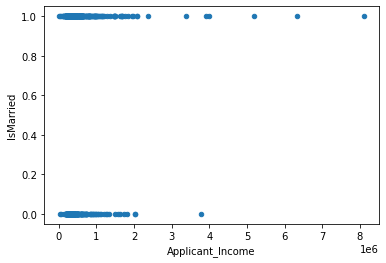

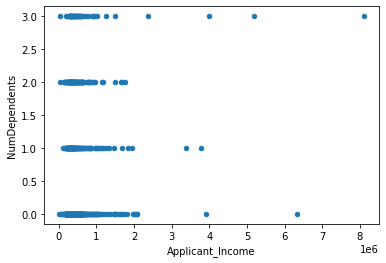

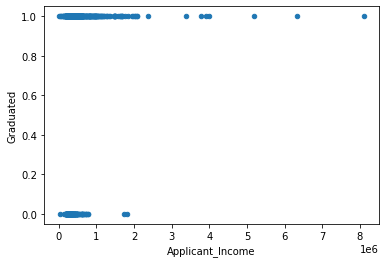

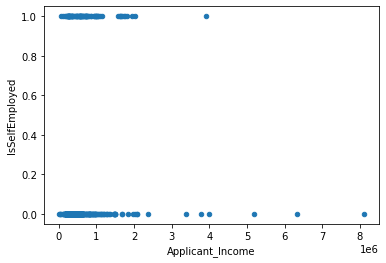

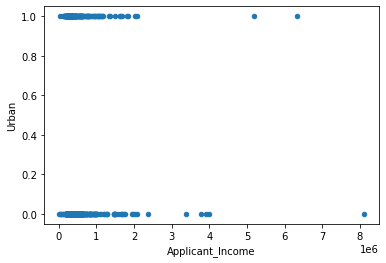

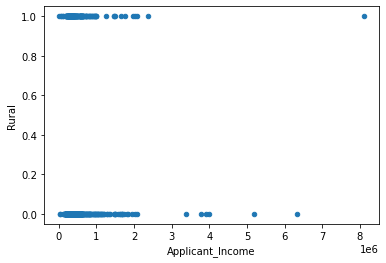

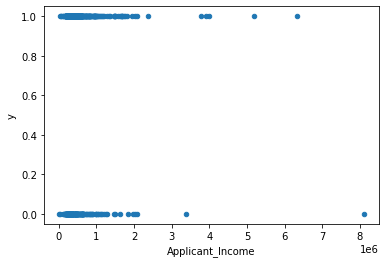

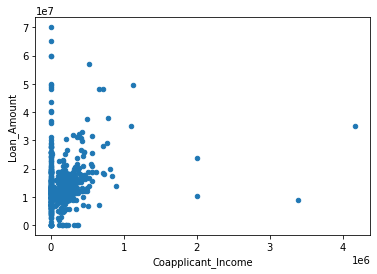

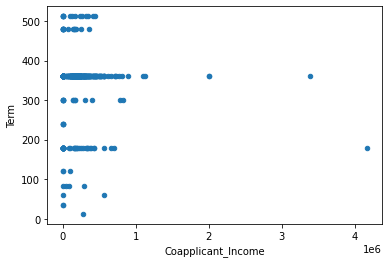

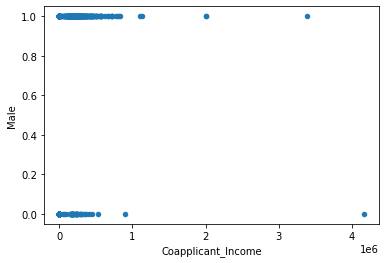

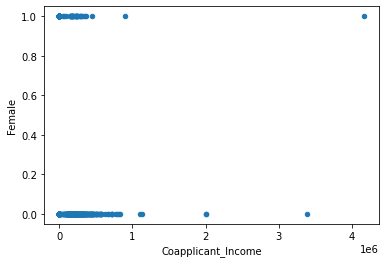

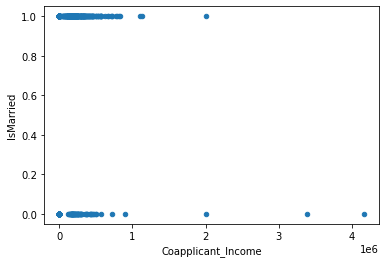

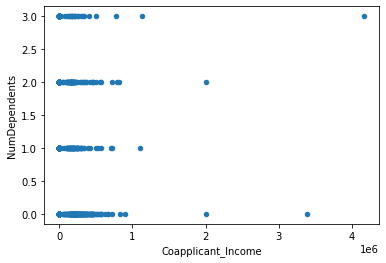

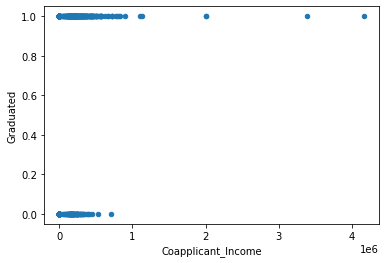

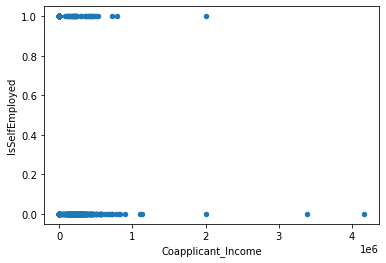

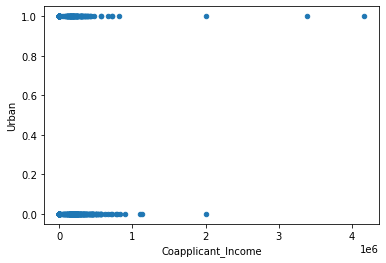

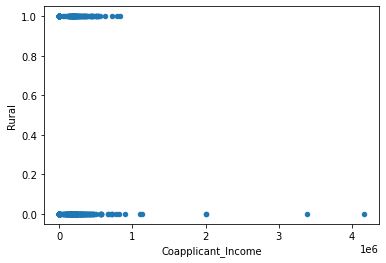

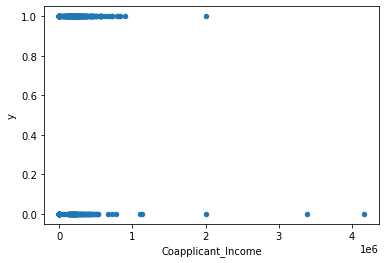

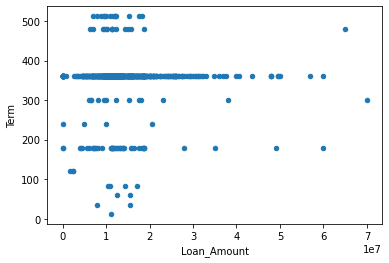

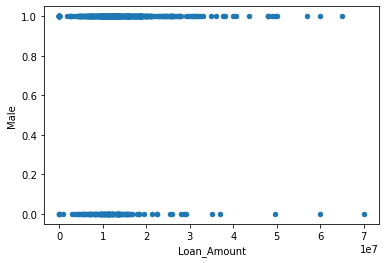

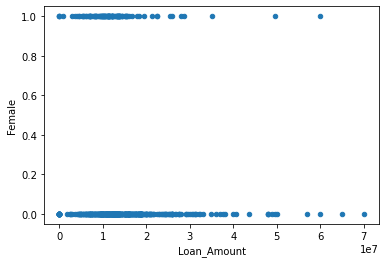

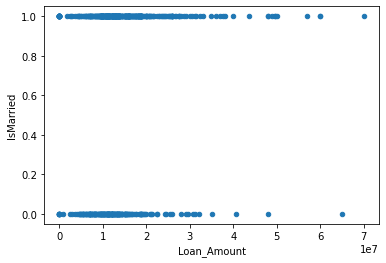

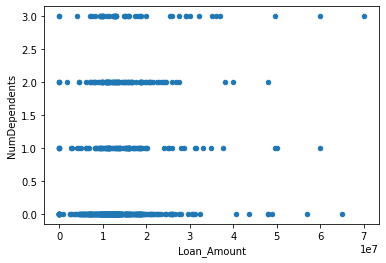

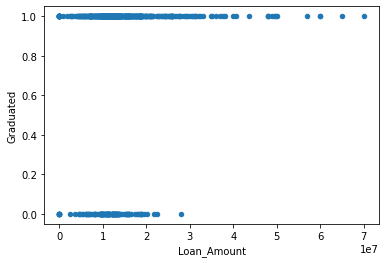

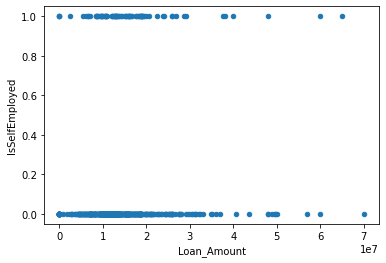

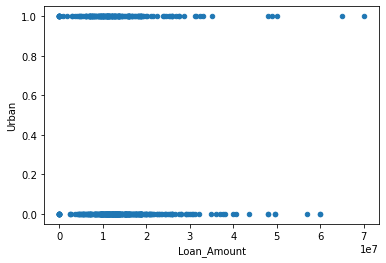

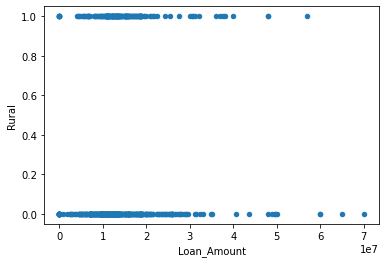

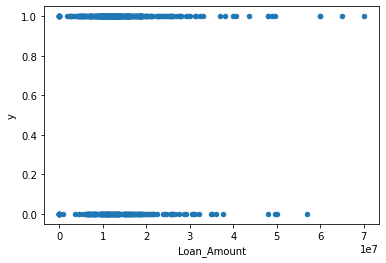

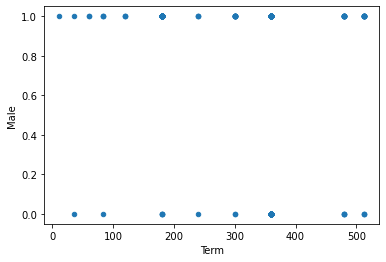

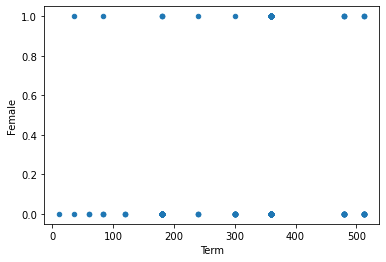

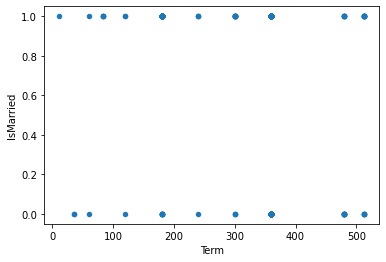

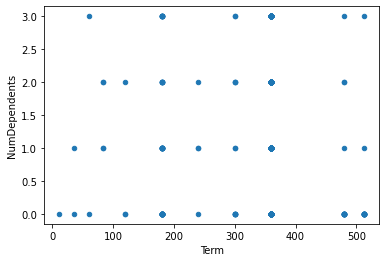

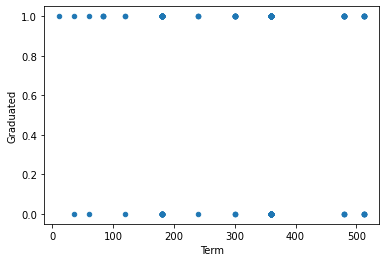

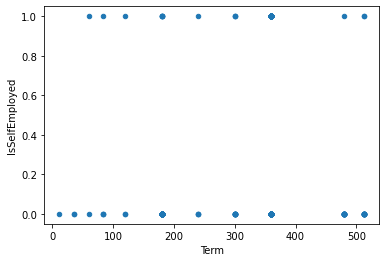

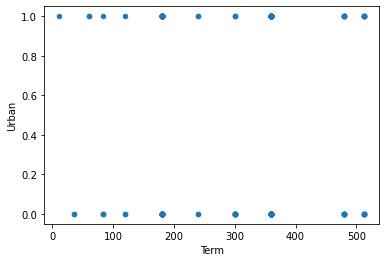

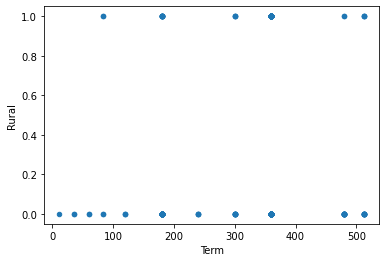

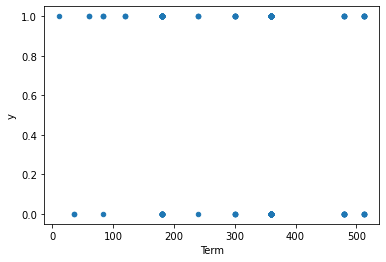

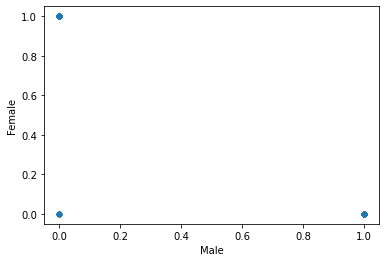

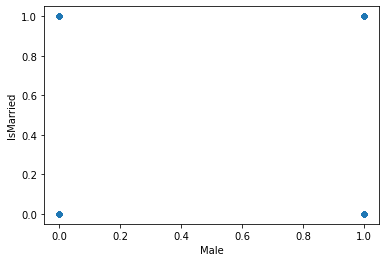

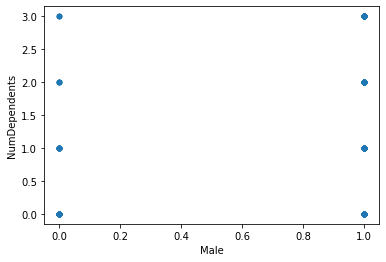

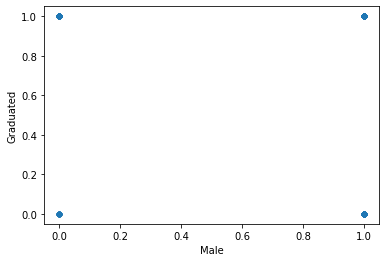

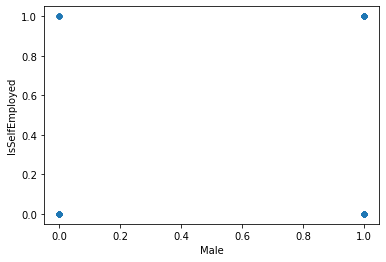

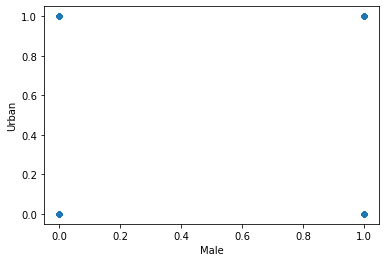

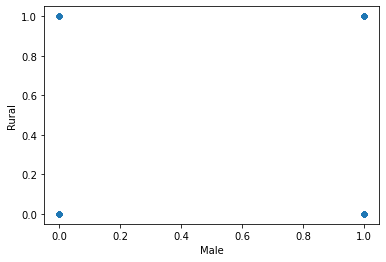

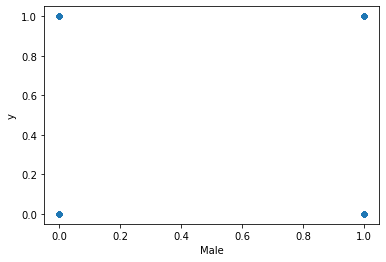

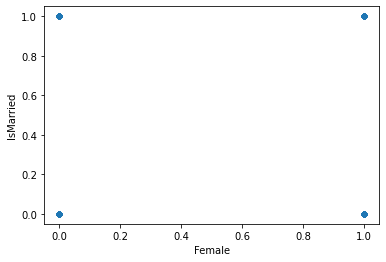

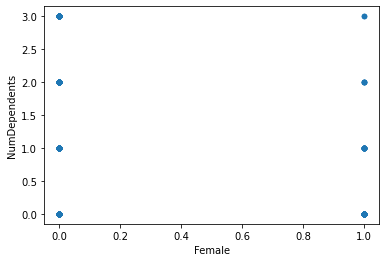

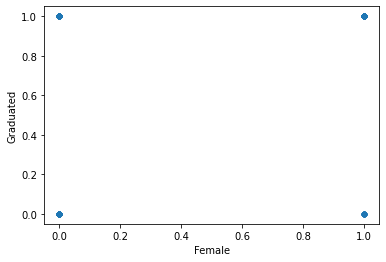

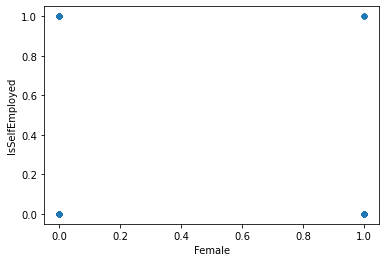

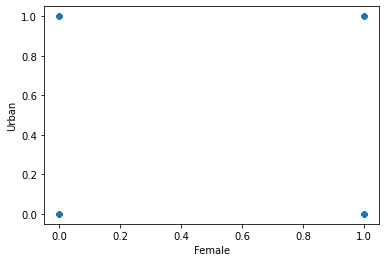

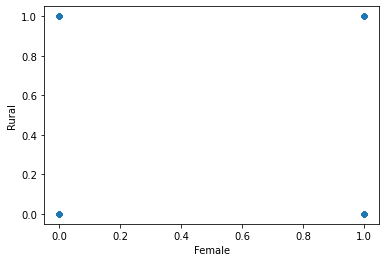

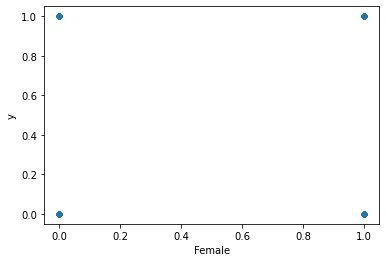

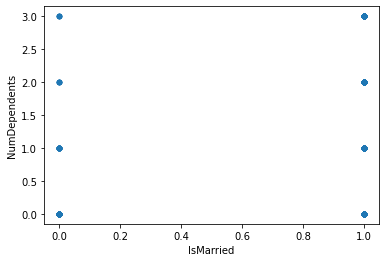

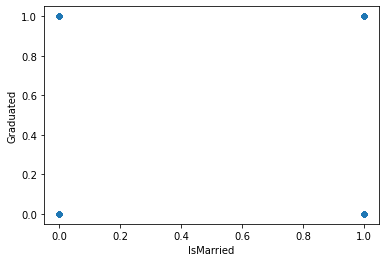

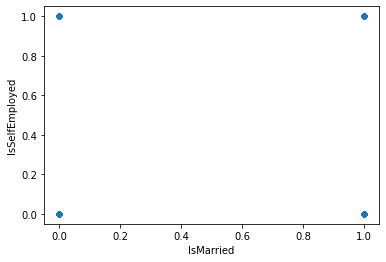

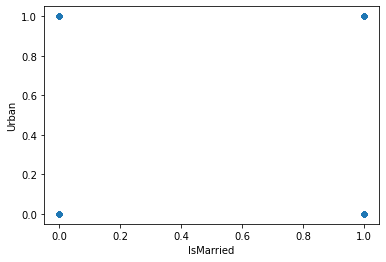

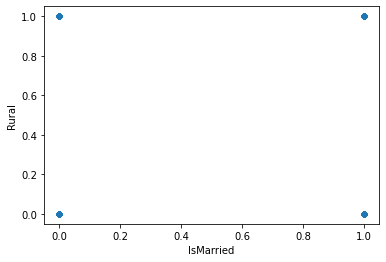

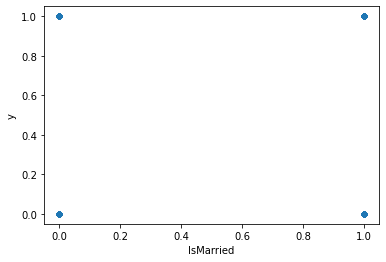

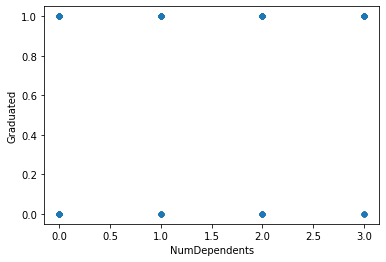

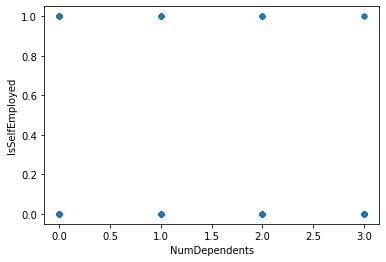

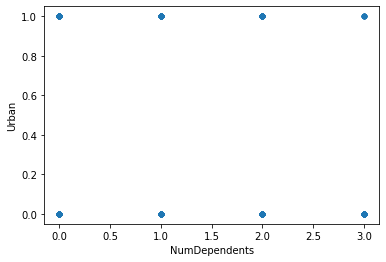

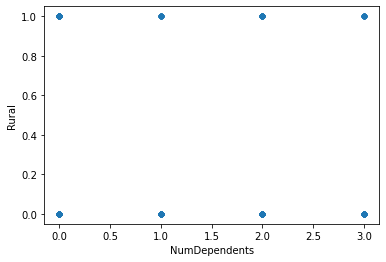

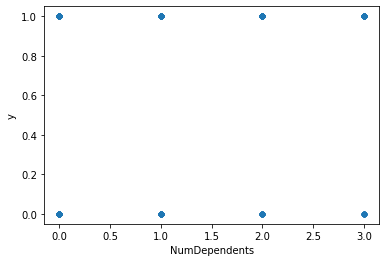

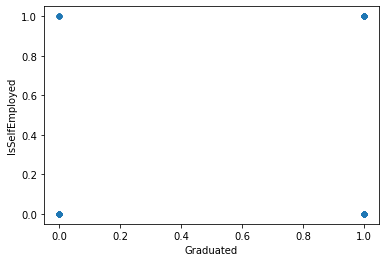

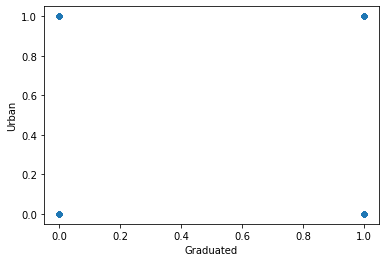

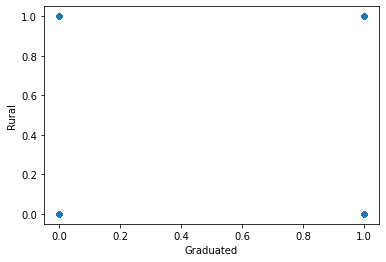

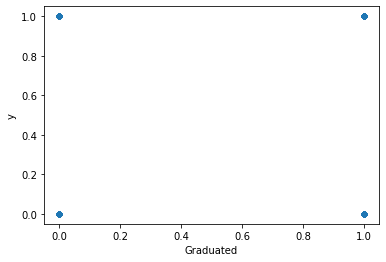

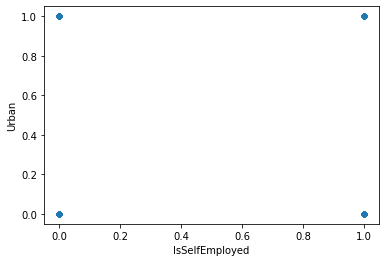

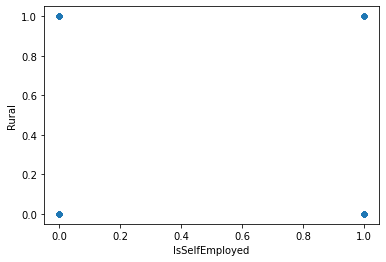

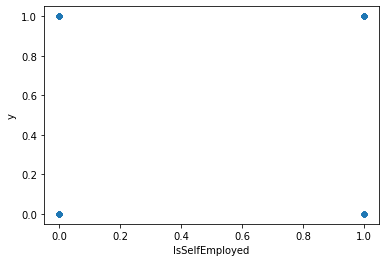

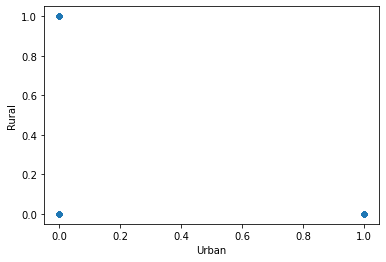

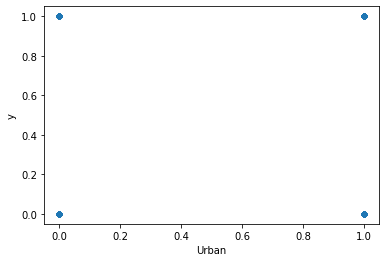

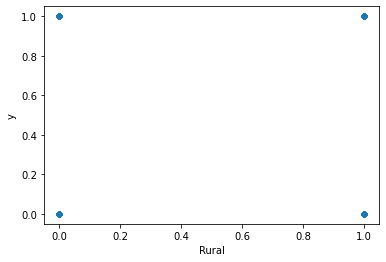

In [67]:
for i in range(len(train.columns)):
    for j in range(i+1, len(train.columns)):
        train.plot.scatter(train.columns[i], train.columns[j]);

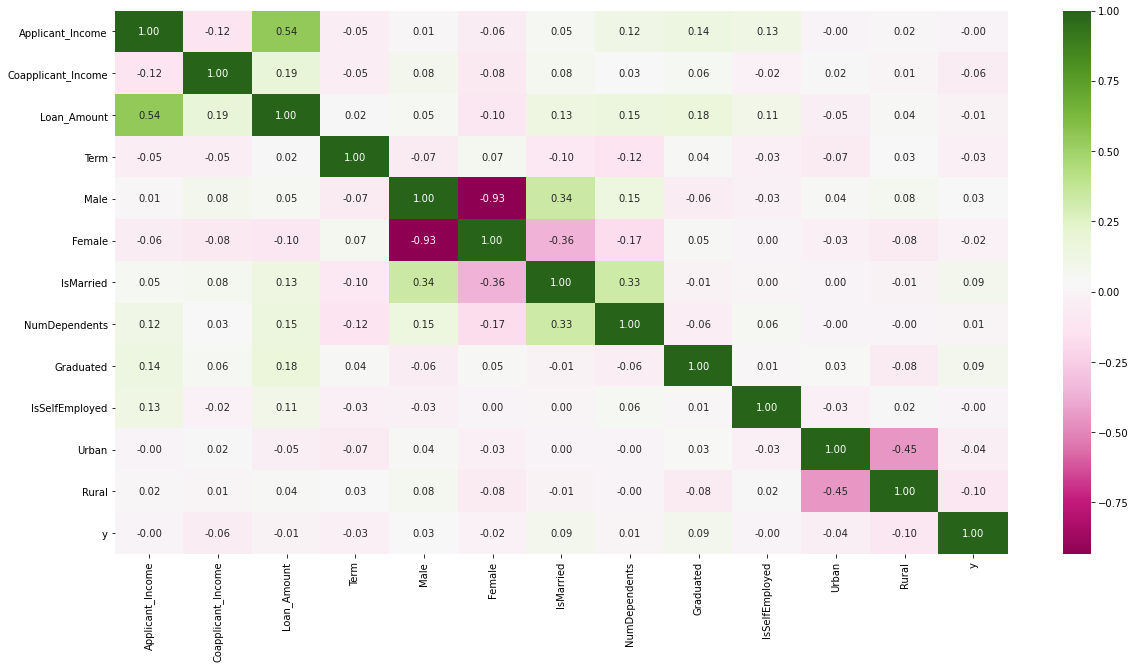

In [70]:
plt.figure(figsize = (20,10))
sns.heatmap(train.corr(), annot=True, fmt=".2f", cmap="PiYG");

In [110]:
train_y = train.y
train_x = train.drop(columns = "y")
X_train, X_valid, y_train, y_valid = train_test_split(
             train_x, train_y, test_size=0.2, random_state=313)

1 Index(['Rural'], dtype='object')
Optimization terminated successfully.
         Current function value: 0.618809
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  491
Model:                          Logit   Df Residuals:                      489
Method:                           MLE   Df Model:                            1
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                 0.01257
Time:                        14:30:07   Log-Likelihood:                -303.84
converged:                       True   LL-Null:                       -307.70
Covariance Type:            nonrobust   LLR p-value:                  0.005419
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9410      0.120      7.819      0.000       0.705       1.177
x1            -0.5745      0.206     -2.795      0.005      -0.977      -0.172
==============================================================================
"""

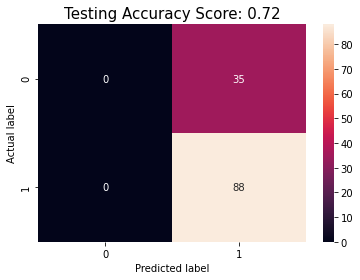

2 Index(['Graduated', 'Rural'], dtype='object')
Optimization terminated successfully.
         Current function value: 0.616266
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  491
Model:                          Logit   Df Residuals:                      488
Method:                           MLE   Df Model:                            2
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                 0.01663
Time:                        14:30:07   Log-Likelihood:                -302.59
converged:                       True   LL-Null:                       -307.70
Covariance Type:            nonrobust   LLR p-value:                  0.006001
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6399      0.222      2.882      0.004       0.205       1.075
x1             0.3731      0.234      1.593      0.111      -0.086       0.832
x2            -0.5468      0.207     -2.645      0.008      -0.952      -0.142
==============================================================================
"""

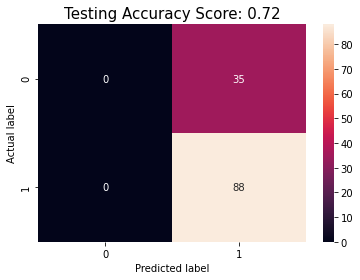

3 Index(['IsMarried', 'Graduated', 'Rural'], dtype='object')
Optimization terminated successfully.
         Current function value: 0.613216
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  491
Model:                          Logit   Df Residuals:                      487
Method:                           MLE   Df Model:                            3
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                 0.02149
Time:                        14:30:08   Log-Likelihood:                -301.09
converged:                       True   LL-Null:                       -307.70
Covariance Type:            nonrobust   LLR p-value:                  0.004170
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4093      0.258      1.585      0.113      -0.097       0.915
x1             0.3522      0.203      1.736      0.083      -0.045       0.750
x2             0.3855      0.235      1.640      0.101      -0.075       0.846
x3            -0.5571      0.208     -2.684      0.007      -0.964      -0.150
==============================================================================
"""

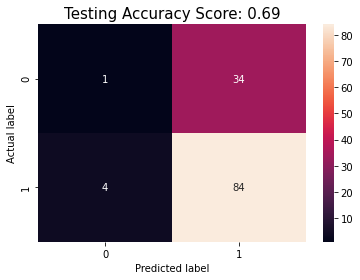

4 Index(['Coapplicant_Income', 'IsMarried', 'Graduated', 'Rural'], dtype='object')
Optimization terminated successfully.
         Current function value: 0.612178
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  491
Model:                          Logit   Df Residuals:                      486
Method:                           MLE   Df Model:                            4
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                 0.02315
Time:                        14:30:08   Log-Likelihood:                -300.58
converged:                       True   LL-Null:                       -307.70
Covariance Type:            nonrobust   LLR p-value:                  0.006549
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4361      0.260      1.680      0.093      -0.073       0.945
x1         -3.745e-07    3.7e-07     -1.012      0.311    -1.1e-06    3.51e-07
x2             0.3767      0.205      1.840      0.066      -0.024       0.778
x3             0.4055      0.236      1.718      0.086      -0.057       0.868
x4            -0.5498      0.208     -2.646      0.008      -0.957      -0.143
==============================================================================
"""

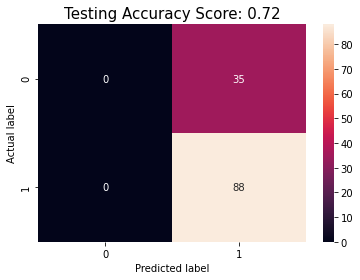

5 Index(['Coapplicant_Income', 'IsMarried', 'Graduated', 'IsSelfEmployed',
       'Rural'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.611729
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  491
Model:                          Logit   Df Residuals:                      485
Method:                           MLE   Df Model:                            5
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                 0.02386
Time:                        14:30:08   Log-Likelihood:                -300.36
converged:                       True   LL-Null:                       -307.70
Covariance Type:            nonrobust   LLR p-value:                   0.01179
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4170      0.261      1.595      0.111      -0.095       0.929
x1         -3.736e-07   3.71e-07     -1.007      0.314    -1.1e-06    3.54e-07
x2             0.3733      0.205      1.822      0.068      -0.028       0.775
x3             0.4011      0.236      1.699      0.089      -0.062       0.864
x4             0.1933      0.294      0.657      0.511      -0.383       0.769
x5            -0.5532      0.208     -2.659      0.008      -0.961      -0.145
==============================================================================
"""

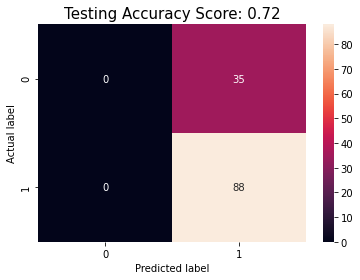

6 Index(['Coapplicant_Income', 'IsMarried', 'Graduated', 'IsSelfEmployed',
       'Urban', 'Rural'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.606812
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  491
Model:                          Logit   Df Residuals:                      484
Method:                           MLE   Df Model:                            6
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                 0.03171
Time:                        14:30:09   Log-Likelihood:                -297.94
converged:                       True   LL-Null:                       -307.70
Covariance Type:            nonrobust   LLR p-value:                  0.003376
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6799      0.291      2.336      0.020       0.109       1.251
x1         -3.756e-07   3.77e-07     -0.997      0.319   -1.11e-06    3.63e-07
x2             0.3766      0.206      1.829      0.067      -0.027       0.780
x3             0.3946      0.237      1.664      0.096      -0.070       0.859
x4             0.1929      0.295      0.653      0.514      -0.386       0.772
x5            -0.5348      0.244     -2.190      0.029      -1.014      -0.056
x6            -0.8132      0.243     -3.341      0.001      -1.290      -0.336
==============================================================================
"""

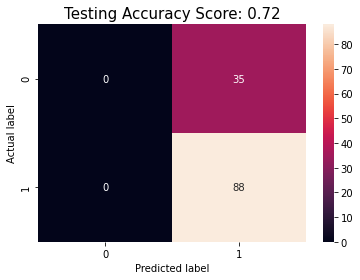

7 Index(['Coapplicant_Income', 'Term', 'IsMarried', 'Graduated',
       'IsSelfEmployed', 'Urban', 'Rural'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.606680
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  491
Model:                          Logit   Df Residuals:                      483
Method:                           MLE   Df Model:                            7
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                 0.03192
Time:                        14:30:09   Log-Likelihood:                -297.88
converged:                       True   LL-Null:                       -307.70
Covariance Type:            nonrobust   LLR p-value:                  0.006390
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8708      0.608      1.432      0.152      -0.321       2.063
x1         -3.721e-07   3.77e-07     -0.988      0.323   -1.11e-06    3.66e-07
x2            -0.0005      0.001     -0.358      0.720      -0.003       0.002
x3             0.3667      0.208      1.765      0.078      -0.040       0.774
x4             0.3972      0.237      1.674      0.094      -0.068       0.862
x5             0.1927      0.295      0.652      0.514      -0.386       0.772
x6            -0.5351      0.244     -2.191      0.028      -1.014      -0.056
x7            -0.8129      0.243     -3.339      0.001      -1.290      -0.336
==============================================================================
"""

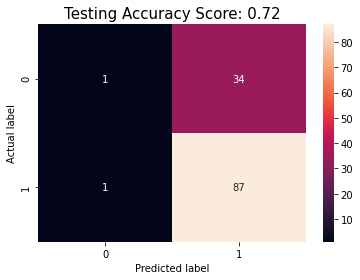

8 Index(['Coapplicant_Income', 'Loan_Amount', 'Term', 'IsMarried', 'Graduated',
       'IsSelfEmployed', 'Urban', 'Rural'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.606680
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  491
Model:                          Logit   Df Residuals:                      482
Method:                           MLE   Df Model:                            8
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                 0.03192
Time:                        14:30:09   Log-Likelihood:                -297.88
converged:                       True   LL-Null:                       -307.70
Covariance Type:            nonrobust   LLR p-value:                   0.01176
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8726      0.613      1.423      0.155      -0.329       2.075
x1         -3.712e-07   3.79e-07     -0.980      0.327   -1.11e-06    3.71e-07
x2         -2.563e-10   1.15e-08     -0.022      0.982   -2.28e-08    2.22e-08
x3            -0.0005      0.001     -0.357      0.721      -0.003       0.002
x4             0.3674      0.210      1.752      0.080      -0.044       0.778
x5             0.3983      0.242      1.643      0.100      -0.077       0.873
x6             0.1934      0.297      0.651      0.515      -0.389       0.776
x7            -0.5352      0.244     -2.191      0.028      -1.014      -0.056
x8            -0.8127      0.244     -3.335      0.001      -1.290      -0.335
==============================================================================
"""

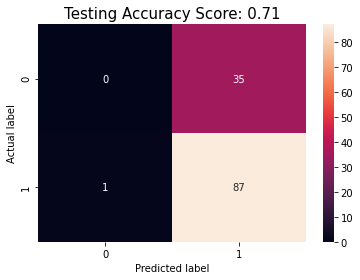

9 Index(['Coapplicant_Income', 'Loan_Amount', 'Term', 'IsMarried',
       'NumDependents', 'Graduated', 'IsSelfEmployed', 'Urban', 'Rural'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.606586
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  491
Model:                          Logit   Df Residuals:                      481
Method:                           MLE   Df Model:                            9
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                 0.03207
Time:                        14:30:10   Log-Likelihood:                -297.83
converged:                       True   LL-Null:                       -307.70
Covariance Type:            nonrobust   LLR p-value:                   0.01961
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8938      0.618      1.447      0.148      -0.317       2.104
x1         -3.809e-07    3.8e-07     -1.001      0.317   -1.13e-06    3.65e-07
x2          1.354e-10   1.16e-08      0.012      0.991   -2.25e-08    2.28e-08
x3            -0.0006      0.002     -0.381      0.703      -0.004       0.002
x4             0.3918      0.225      1.742      0.081      -0.049       0.833
x5            -0.0325      0.107     -0.303      0.762      -0.243       0.178
x6             0.3935      0.243      1.620      0.105      -0.083       0.870
x7             0.1991      0.298      0.668      0.504      -0.385       0.783
x8            -0.5370      0.244     -2.197      0.028      -1.016      -0.058
x9            -0.8130      0.244     -3.336      0.001      -1.291      -0.335
==============================================================================
"""

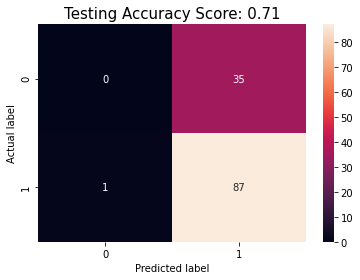

10 Index(['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term',
       'IsMarried', 'NumDependents', 'Graduated', 'IsSelfEmployed', 'Urban',
       'Rural'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.605798
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  491
Model:                          Logit   Df Residuals:                      480
Method:                           MLE   Df Model:                           10
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                 0.03333
Time:                        14:30:10   Log-Likelihood:                -297.45
converged:                       True   LL-Null:                       -307.70
Covariance Type:            nonrobust   LLR p-value:                   0.02478
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9291      0.620      1.498      0.134      -0.287       2.145
x1         -1.593e-07    1.8e-07     -0.884      0.377   -5.12e-07    1.94e-07
x2         -4.582e-07   3.96e-07     -1.158      0.247   -1.23e-06    3.17e-07
x3          6.805e-09   1.38e-08      0.494      0.622   -2.02e-08    3.38e-08
x4            -0.0007      0.002     -0.465      0.642      -0.004       0.002
x5             0.3881      0.225      1.724      0.085      -0.053       0.829
x6            -0.0278      0.108     -0.258      0.796      -0.239       0.183
x7             0.4090      0.244      1.679      0.093      -0.068       0.886
x8             0.2154      0.298      0.722      0.470      -0.369       0.800
x9            -0.5288      0.245     -2.160      0.031      -1.008      -0.049
x10           -0.8136      0.244     -3.335      0.001      -1.292      -0.336
==============================================================================
"""

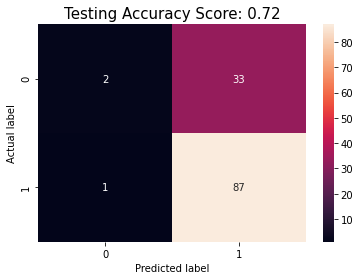

11 Index(['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term', 'Male',
       'IsMarried', 'NumDependents', 'Graduated', 'IsSelfEmployed', 'Urban',
       'Rural'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.605798
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  491
Model:                          Logit   Df Residuals:                      479
Method:                           MLE   Df Model:                           11
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                 0.03333
Time:                        14:30:11   Log-Likelihood:                -297.45
converged:                       True   LL-Null:                       -307.70
Covariance Type:            nonrobust   LLR p-value:                   0.03881
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9272      0.642      1.444      0.149      -0.332       2.186
x1         -1.593e-07    1.8e-07     -0.884      0.377   -5.12e-07    1.94e-07
x2         -4.588e-07   3.99e-07     -1.149      0.251   -1.24e-06    3.24e-07
x3          6.805e-09   1.38e-08      0.494      0.622   -2.02e-08    3.38e-08
x4            -0.0007      0.002     -0.465      0.642      -0.004       0.002
x5             0.0030      0.264      0.011      0.991      -0.514       0.520
x6             0.3874      0.233      1.661      0.097      -0.070       0.845
x7            -0.0278      0.108     -0.258      0.796      -0.239       0.183
x8             0.4091      0.244      1.676      0.094      -0.069       0.888
x9             0.2155      0.298      0.722      0.470      -0.370       0.801
x10           -0.5290      0.245     -2.155      0.031      -1.010      -0.048
x11           -0.8139      0.245     -3.316      0.001      -1.295      -0.333
==============================================================================
"""

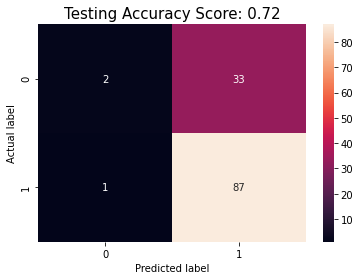

12 Index(['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term', 'Male',
       'Female', 'IsMarried', 'NumDependents', 'Graduated', 'IsSelfEmployed',
       'Urban', 'Rural'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.605773
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  491
Model:                          Logit   Df Residuals:                      478
Method:                           MLE   Df Model:                           12
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                 0.03337
Time:                        14:30:11   Log-Likelihood:                -297.43
converged:                       True   LL-Null:                       -307.70
Covariance Type:            nonrobust   LLR p-value:                   0.05760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0370      0.946      1.096      0.273      -0.818       2.892
x1         -1.615e-07   1.81e-07     -0.893      0.372   -5.16e-07    1.93e-07
x2         -4.606e-07   3.99e-07     -1.153      0.249   -1.24e-06    3.22e-07
x3          6.655e-09   1.38e-08      0.482      0.630   -2.04e-08    3.37e-08
x4            -0.0007      0.002     -0.462      0.644      -0.004       0.002
x5            -0.1011      0.711     -0.142      0.887      -1.494       1.292
x6            -0.1184      0.748     -0.158      0.874      -1.585       1.348
x7             0.3841      0.234      1.640      0.101      -0.075       0.843
x8            -0.0288      0.108     -0.267      0.790      -0.240       0.183
x9             0.4095      0.244      1.678      0.093      -0.069       0.888
x10            0.2129      0.299      0.712      0.476      -0.373       0.799
x11           -0.5292      0.245     -2.156      0.031      -1.010      -0.048
x12           -0.8146      0.246     -3.318      0.001      -1.296      -0.333
==============================================================================
"""

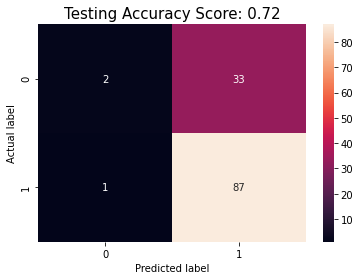

0.7235772357723578 10


In [111]:
best_acc = 0
best_k = -1
for k in range(1, len(X_train.columns)+1):
    k_best = SelectKBest(k=k).fit(X_train, y_train)
    mask = k_best.get_support()
    k_best_features = X_train.columns[mask]
    X_new = k_best.transform(X_train)
    clf = LogisticRegression(random_state=313).fit(X_new, y_train)
    X_valid_new = k_best.transform(X_valid)
    y_pred = clf.predict(X_valid_new)
    cm = metrics.confusion_matrix(y_valid, y_pred)
    print(k, k_best_features)
    X_sm = sm.add_constant(X_new)
    log_reg = sm.Logit(y_train, X_sm).fit()
    display(log_reg.summary())
    acc = clf.score(X_valid_new, y_valid)
    sns.heatmap(cm, annot = True)
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Testing Accuracy Score: {:.2f}'.format(acc)
    plt.title(all_sample_title, size = 15);
    plt.show()
    if acc > best_acc:
        best_acc = acc
        best_k = k
    
print(best_acc, best_k)

In [112]:
test = pd.read_csv("loan_test.csv")
test.isna().sum()

Gender                11
Married                0
Dependents            10
Education              0
Self_Employed         23
Applicant_Income       0
Coapplicant_Income     0
Loan_Amount            0
Term                   6
Credit_History        29
Area                   0
dtype: int64

In [113]:
test["Male"] = 0
test["Female"] = 0
test.loc[test.Gender == "Male", "Male"] = 1
test.loc[test.Gender == "Female", "Female"] = 1
test["IsMarried"] = 0
num_married = (test.Married == "Yes").sum()
num_unmarried = (test.Married == "No").sum()
if num_married > num_unmarried:
    # nan will be married
    test.loc[test.Married != "No", "IsMarried"] = 1
else:
    # nan will be unmarried
    test.loc[test.Married == "Yes", "IsMarried"] = 1
has_zero_dependent = (test.Dependents == "0").sum()
has_one_dependent = (test.Dependents == "1").sum()
has_two_dependent = (test.Dependents == "2").sum()
has_three_plus_dependent = (test.Dependents == "3+").sum()
max_count_dependent = test.Dependents.value_counts().max()
test["NumDependents"] = 0
if has_zero_dependent == max_count_dependent:
    # nan will be 0; so do nothing
    test.loc[test.Dependents == "1", "NumDependents"] = 1
    test.loc[test.Dependents == "2", "NumDependents"] = 2
    # convert 3+ to 3
    test.loc[test.Dependents == "3+", "NumDependents"] = 3
elif has_one_dependent == max_count_dependent:
    # nan will be 1
    test.loc[(test.Dependents != "0") &
              (test.Dependents != "2") &
              (test.Dependents != "3+"), "NumDependents"] = 1
    test.loc[test.Dependents == "2", "NumDependents"] = 2
    # convert 3+ to 3
    test.loc[test.Dependents == "3+", "NumDependents"] = 3
elif has_two_dependent == max_count_dependent:
    test.loc[test.Dependents == "1", "NumDependents"] = 1
    # nan will be 2
    test.loc[(test.Dependents != "0") &
              (test.Dependents != "1") &
              (test.Dependents != "3+"), "NumDependents"] = 2
    # convert 3+ to 3
    test.loc[test.Dependents == "3+", "NumDependents"] = 3
else: # max == 3+
    test.loc[test.Dependents == "1", "NumDependents"] = 1
    test.loc[test.Dependents == "2", "NumDependents"] = 2
    # nan will be 3+ & convert 3+ to 3
    test.loc[(test.Dependents != "0") &
              (test.Dependents != "1") &
              (test.Dependents != "2"), "NumDependents"] = 3       
test["Graduated"] = 0
num_graduated = (test.Education == "Graduate").sum()
num_ungraduated = (test.Education == "Not Graduate").sum()
if num_graduated > num_ungraduated:
    test.loc[test.Education != "Not Graduate", "Graduated"] = 1
else:
    test.loc[test.Education == "Graduate", "Graduated"] = 1
test["IsSelfEmployed"] = 0
num_self_employed = (test.Self_Employed == "Yes").sum()
num_not_self_employed = (test.Self_Employed == "No").sum()
if num_self_employed > num_not_self_employed:
    test.loc[test.Self_Employed != "No", "IsSelfEmployed"] = 1
else:
    test.loc[test.Self_Employed == "Yes", "IsSelfEmployed"] = 1
num_w_credit_hist = (test.Credit_History == 1.0).sum()
num_wo_credit_hist = (test.Credit_History == 0.0).sum()
if num_w_credit_hist > num_wo_credit_hist:
    test.loc[test.Self_Employed != 0.0, "Credit_History"] = 1.0
else:
    test.loc[test.Self_Employed != 1.0, "Credit_History"] = 0.0
# term
test.loc[test.Term.isna(), "Term"] = test.Term.value_counts().max()
test["Urban"] = 0
test["Rural"] = 0
test.loc[test.Area == "Urban", "Urban"] = 1
test.loc[test.Area == "Rural", "Rural"] = 1

In [114]:
test = test[["Applicant_Income", "Coapplicant_Income",
               "Loan_Amount", "Term", "Male", "Female",
               "IsMarried", "NumDependents",
               "Graduated", "IsSelfEmployed",
               "Urban", "Rural"]]

In [124]:
k_best = SelectKBest(k=best_k).fit(train_x, train_y)
mask = k_best.get_support()
k_best_features = train_x.columns[mask]
X_new = k_best.transform(train_x)
clf = LogisticRegression(random_state=313).fit(X_new, train_y)
test_new = k_best.transform(test)
y_pred = clf.predict(test_new)
X_sm = sm.add_constant(X_new)
log_reg = sm.Logit(train_y, X_sm).fit()
display(log_reg.summary(xname=["const"] + list(k_best_features)))

Optimization terminated successfully.
         Current function value: 0.599904
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  614
Model:                          Logit   Df Residuals:                      603
Method:                           MLE   Df Model:                           10
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                 0.03435
Time:                        14:32:54   Log-Likelihood:                -368.34
converged:                       True   LL-Null:                       -381.45
Covariance Type:            nonrobust   LLR p-value:                  0.003469
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6654      0.808      0.823      0.410      -0.919       2.249
Coapplicant_Income -4.957e-07   3.25e-07     -1.525      0.127   -1.13e-06    1.41e-07
Loan_Amount         -4.72e-09   1.07e-08     -0.443      0.658   -2.56e-08    1.62e-08
Term                  -0.0012      0.001     -0.874      0.382      -0.004       0.001
Male                   0.4888      0.595      0.821      0.412      -0.678       1.656
Female                 0.4221      0.632      0.668      0.504      -0.816       1.660
IsMarried              0.4561      0.209      2.183      0.029       0.047       0.866
NumDependents         -0.0414      0.096     -0.433      0.665      -0.229       0.146
Graduated              0.4725      0.213      2.214      0.027       0.054       0.891
Urban                 -0.5680      0.219     -2.596      0.009      -0.997      -0.139
Rural                 -0.7081      0.223     -3.182      0.001      -1.144      -0.272
======================================================================================
"""